In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

## Plot the experimental, initial simulation and iterated simulation curves

In [100]:
def plotSimulations(initialSims, pathExp, pathSim, title, CPLaw, plotIterations = False):
    plt.figure(figsize=(10, 8))
    # The simulation curves from DAMASK are in true stress-true strain
    # preprocess them into flow curves in order to compare with the experimental curve
    initial_data = np.load(f'{pathSim}/initial_simulations.npy', allow_pickle=True)
    initial_data = initial_data.tolist()
    if CPLaw == "PH":
        convertUnit = 1
    elif CPLaw == "DB":
        convertUnit = 1e-6
    if plotIterations:
        full_data = np.load(f'{pathSim}/simulations.npy', allow_pickle=True)
        full_data = full_data.tolist()
    
    for curve in initial_data.values():
        trueStress = curve[1] * convertUnit
        truePlasticStrain = curve[0] 
        plt.plot(truePlasticStrain, trueStress, c='orange', alpha=0.2)
    plt.plot(truePlasticStrain, trueStress, label = f"Initial simulations x{initialSims}",c='orange', alpha=0.2)
    allstrains = list(map(lambda x: x[0], list(initial_data.values())))
    simStrain = np.array(allstrains).mean(axis=0)

    exp_curve = pd.read_csv(pathExp)
    exp_stress = exp_curve.iloc[:,0] * convertUnit # Getting the experimental stress
    exp_strain = exp_curve.iloc[:,1] # Getting the experimental strain
    plt.plot(exp_strain, exp_stress, label = f"Experimental curve")
    
    # def calculateIndex(stress, strain):
    #     i = 0
    #     while strain[i] <= 0.002:
    #         i += 1
    #     return stress[i]
    # print(calculateIndex(exp_stress, exp_strain))
    
    # If you want to plot only some specific iterations, set plotExactIterationCheck to True
    # and specify the iteration number
    plotExactIterationCheck = True
    plotExactIteration = [12,13]
    if plotIterations:
        if CPLaw == "PH":
            titleParams = "Parameter: (alpha, h0, tau0, taucs)"
        elif CPLaw == "DB":
            titleParams = "Parameter: (dipole, islip, omega, p, q, tausol)"
        plt.plot([], [], ' ', label=titleParams)
        parameters = list(full_data)[initialSims:]
        strainstress = list(full_data.values())[initialSims:]
        simCurves = zip(parameters, strainstress)
        i = 0
        for parameter, strainstress in simCurves:
            trueStress = strainstress[1] * convertUnit
            truePlasticStrain = strainstress[0]
            i += 1
            if plotExactIterationCheck:
                if i in plotExactIteration:
                    # print(calculateIndex(trueStress, truePlasticStrain))
                    plt.plot(truePlasticStrain, trueStress, label = f"Iteration {i}: {parameter}")
            else: 
                plt.plot(truePlasticStrain, trueStress, label = f"Iteration {i}: {parameter}")
    # Uncomment these lines to have a closer view. Change the limit as you want to see better
    #plt.xlim([0.002,0.1])
    #plt.ylim([100,125])
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel = "Strain (-)")
    plt.ylabel(ylabel = "Stress (MPa)")
    plt.legend(loc=2, prop={'size': 12})
    plt.show()
    return simStrain, exp_stress, exp_strain


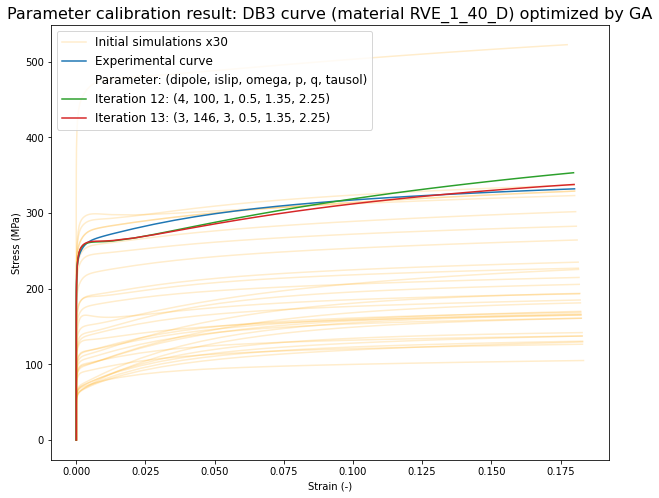

In [101]:
# Please change these configurations
# Number of initial simulations
initialSims = 30

# material used
material = "RVE_1_40_D"
# material = "512grains512"

# Used algorithm
algorithm = "GA"
# algorithm = "BA"

# Crystal plasticity law
# CPLaw = "PH"
CPLaw = "DB"

# Curve index
# curveIndex = 1
# curveIndex = 2
curveIndex = 3

titleOptimized = f"Parameter calibration result: {CPLaw}{curveIndex} curve (material {material}) optimized by {algorithm}"
titleNoOptimized = f"Initial simulations and experimental curve of {CPLaw}{curveIndex} (material {material})"
pathExp = f"targets_{material}/{CPLaw}{curveIndex}.csv"
pathSim = f"results_{material}/{CPLaw}{curveIndex}_{algorithm}"

# Plot only initial simulations and experimental curve
# simStrain, exp_stress, exp_strain = plotSimulations(initialSims, pathExp, pathSim, titleNoOptimized, CPLaw)
# Plot initial simulations, experimental curve and iterated simulation results
simStrain, exp_stress, exp_strain = plotSimulations(initialSims, pathExp, pathSim, titleOptimized, CPLaw, True)

## Plot fitness for the curves

In [46]:
def D1(exp_stress, sim_stress): 
    return np.sqrt(np.sum(np.square(exp_stress - sim_stress))/np.sum(np.square(exp_stress)))

def D2(exp_stress, sim_stress, sim_strain): 
    exp_stress_d1 = np.diff(exp_stress)/np.diff(sim_strain)  
    sim_stress_d1 = np.diff(sim_stress)/np.diff(sim_strain)
    return np.sqrt(np.sum(np.square(sim_stress_d1 - exp_stress_d1))/np.sum(np.square(exp_stress_d1)))

def D3(exp_stress, sim_stress):
    return np.max(np.sqrt(np.square(exp_stress - sim_stress)/sum(np.square(exp_stress))))

def D4(exp_stress, sim_stress, sim_strain):
    exp_stress_d1 = np.diff(exp_stress)/np.diff(sim_strain)
    sim_stress_d1 = np.diff(sim_stress)/np.diff(sim_strain)
    return np.max(np.sqrt(np.square(sim_stress_d1 - exp_stress_d1)/np.sum(np.square(exp_stress_d1))))

def fitness_hardening(exp_stress, sim_stress, sim_strain, w1, w2, w3, w4):
    return ( w1*D1(exp_stress, sim_stress) + w2*D2(exp_stress, sim_stress, sim_strain) 
            + w3*D3(exp_stress, sim_stress) + w4*D4(exp_stress, sim_stress, sim_strain))

w1 = 0.8
w2 = 0.0005
w3 = 0.19
w4 = 0.0005

# Requiring that the interpolatedStrain must lie inside the range of strain
def interpolatedStressFunction(stress, strain, interpolatedStrain):
    # interpolated function fits the stress-strain curve data 
    interpolatedFunction = interp1d(strain, stress)
    # Calculate the stress values at the interpolated strain points
    interpolatedStress = interpolatedFunction(interpolatedStrain)
    return interpolatedStress 

In [47]:
# D1 loss function: L2 loss 
plt.rc('font', size=20)          # controls default text sizes

# Results of each objective functions
resD1 = []
resD2 = []
resD3 = []
resD4 = []
res_fit = []

full_data = np.load(f'{pathSim}/simulations.npy', allow_pickle=True)
full_data = full_data.tolist()

numberOfGen = len(full_data) - initialSims

# Fix this labels for the correct number of generations
labelsModel = ['1st Iteration', '2nd Iteration', '3rd Iteration', '4th Iteration','5th Iteration', 
          '6th Iteration', '7th Iteration', '8th Iteration', '9th Iteration', '10th Iteration', '11th Iteration' ]
labels = labelsModel[:numberOfGen]

dropUpperEnd = 2 # Please change this
# interpolatedStrain will be the interpolating strain for all curves (experimental, initial simulation and iterated simulation)
interpolatedStrain = simStrain[:-dropUpperEnd]
exp_target = interpolatedStressFunction(exp_stress, exp_strain, interpolatedStrain)
parameters = list(full_data)[initialSims:]
strainstress = list(full_data.values())[initialSims:]
simCurves = zip(parameters, strainstress)

for parameter, strainstress in simCurves:
    trueStress = strainstress[1]
    truePlasticStrain = strainstress[0]
    sim_stress = interpolatedStressFunction(trueStress, truePlasticStrain, interpolatedStrain)
    resD1.append(D1(exp_target, sim_stress))
    resD2.append(D2(exp_target, sim_stress, interpolatedStrain))
    resD3.append(D3(exp_target, sim_stress))
    resD4.append(D4(exp_target, sim_stress, interpolatedStrain))
    
    res_fit.append(fitness_hardening(exp_target, sim_stress, interpolatedStrain, w1, w2, w3, w4))

print("D1 is: ")
print(resD1)
print("D2 is: ")
print(resD2)
print("D3 is: ")
print(resD3)
print("D4 is: ")
print(resD4)

width = 0.55       # the width of the bars: can also be len(x) sequence
L1 = np.array(resD1)[-numberOfGen:]*w1
L2 = np.array(resD2)[-numberOfGen:]*w2
L3 = np.array(resD3)[-numberOfGen:]*w3
L4 = np.array(resD4)[-numberOfGen:]*w4

print("L1 is: ")
print(resD1)
print("L2 is: ")
print(resD2)
print("L3 is: ")
print(resD3)
print("L4 is: ")
print(resD4)

D1 is: 
[0.26963881613282137, 0.265163856789934, 0.2725210322134751, 0.05660622999129758, 0.1016616610161041, 0.05024307001302882, 0.026387467871653317]
D2 is: 
[4869707671648.106, 0.20527234707179456, 4869707671648.106, 4336.337710151246, 4869707671648.106, 4869707671648.106, 4336.337765532864]
D3 is: 
[0.08626297991286355, 0.0859020761553585, 0.08698997234626657, 0.019417727923167392, 0.025914265321594656, 0.01496951477263917, 0.019529940675906417]
D4 is: 
[4869707671648.106, 0.16784637601106545, 4869707671648.106, 4336.337710133658, 4869707671648.106, 4869707671648.106, 4336.337765515075]
L1 is: 
[0.26963881613282137, 0.265163856789934, 0.2725210322134751, 0.05660622999129758, 0.1016616610161041, 0.05024307001302882, 0.026387467871653317]
L2 is: 
[4869707671648.106, 0.20527234707179456, 4869707671648.106, 4336.337710151246, 4869707671648.106, 4869707671648.106, 4336.337765532864]
L3 is: 
[0.08626297991286355, 0.0859020761553585, 0.08698997234626657, 0.019417727923167392, 0.025914265

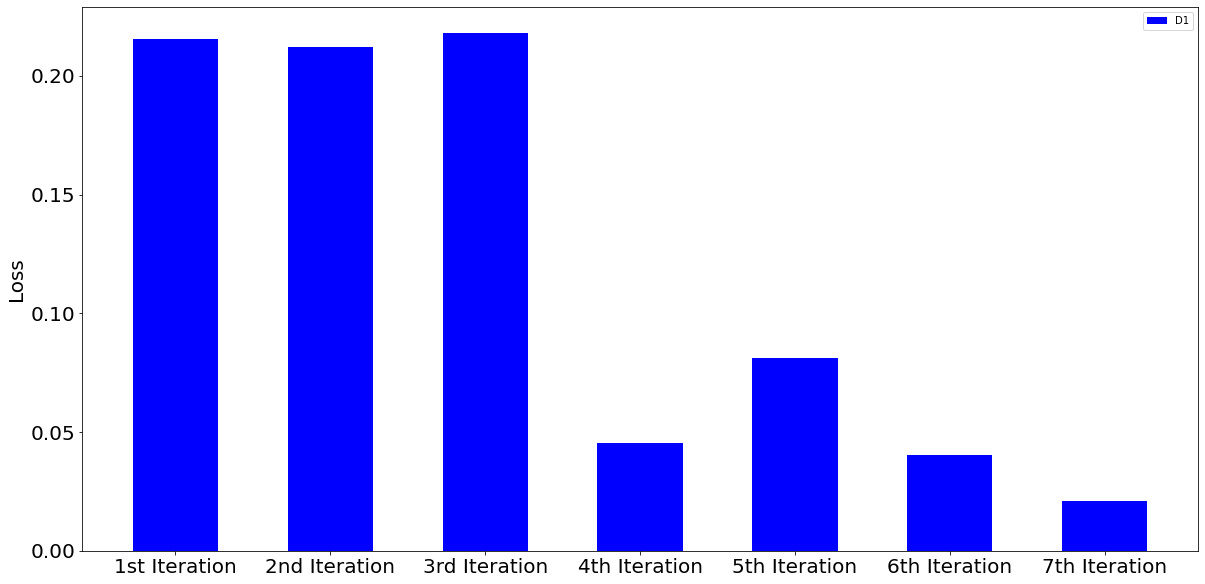

In [48]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L1, width, label='D1', color = "blue")
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 10})
plt.show()

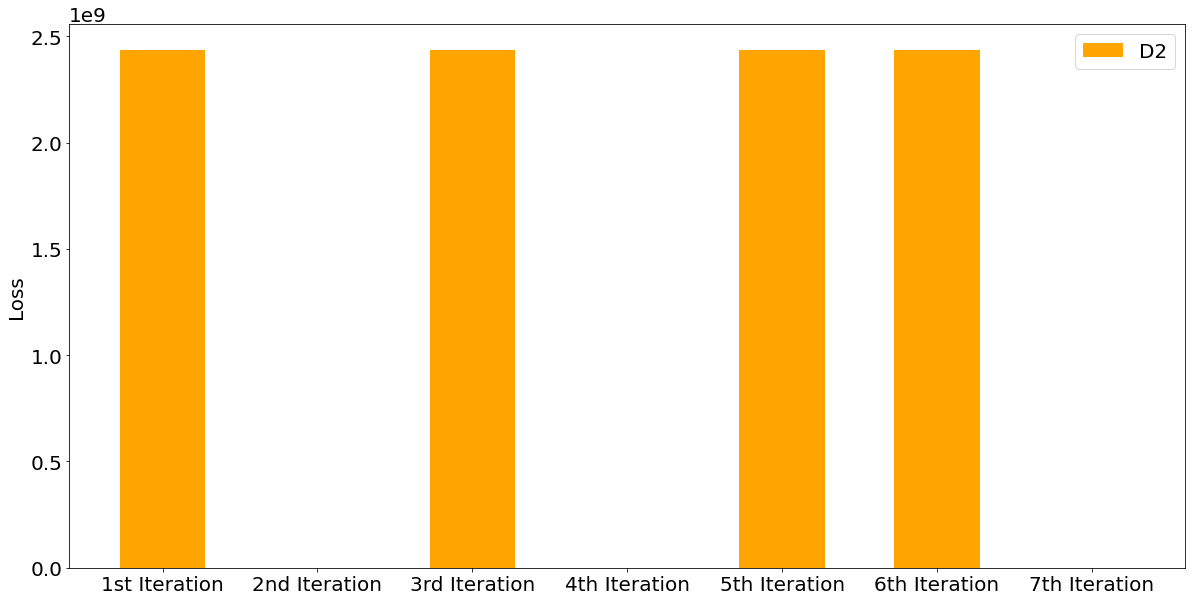

In [49]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L2, width, label='D2', color = "orange")
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()

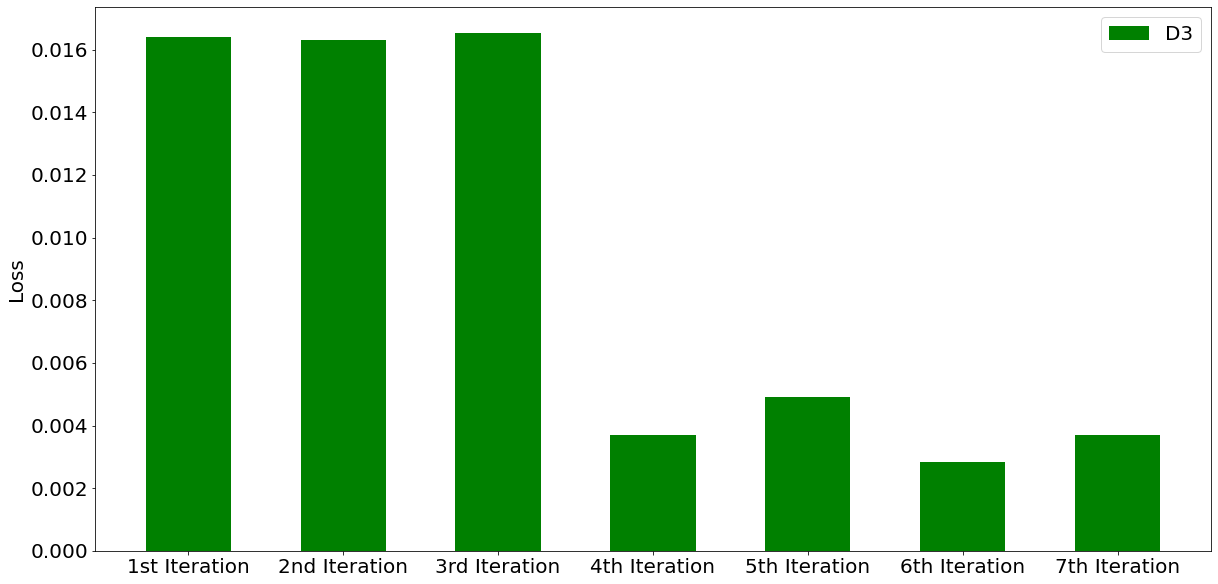

In [50]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L3, width, label='D3', color = "green")
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()

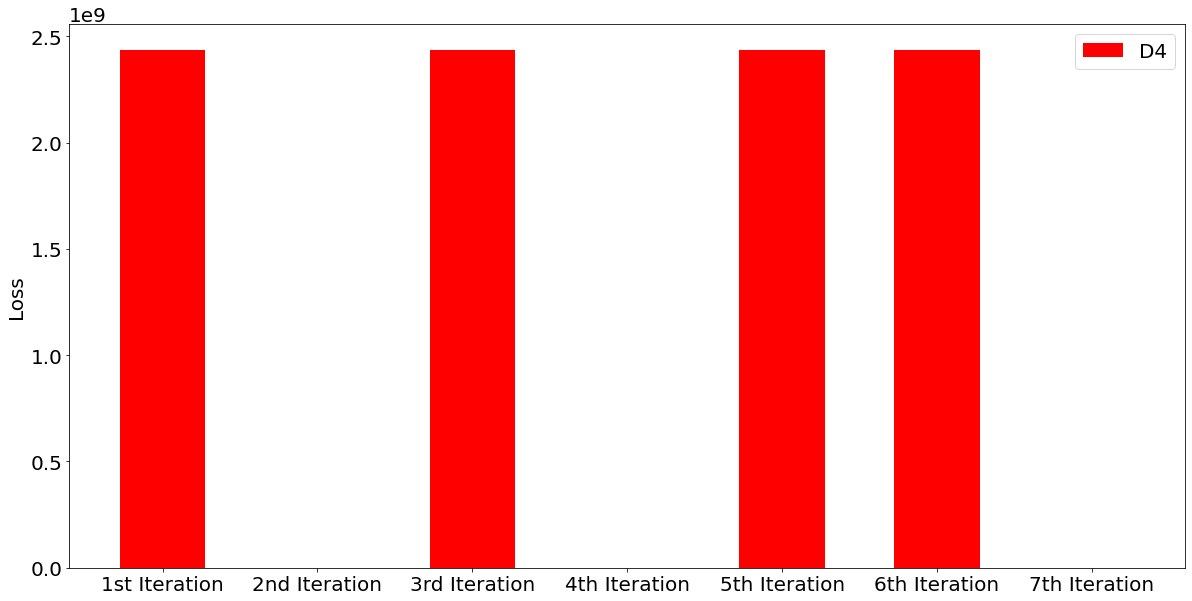

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L4, width, label='D4', color = "red")
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()

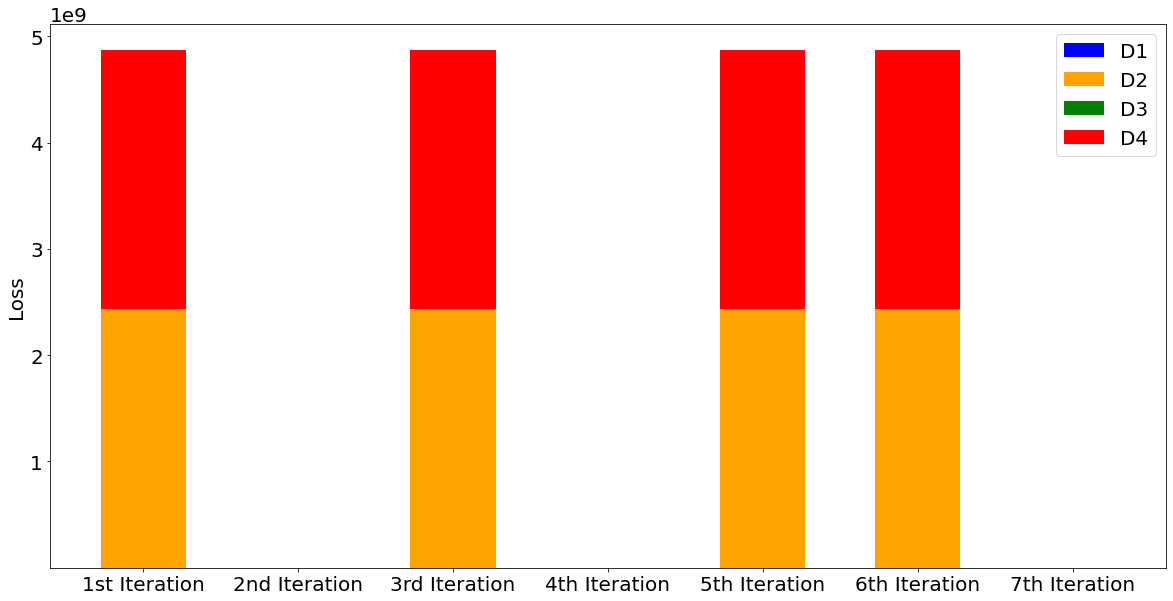

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L1, width, label='D1', color = "blue")
ax.bar(labels, L2, width, bottom=L1 , label='D2', color = "orange")
ax.bar(labels, L3, width, bottom=L1+L2, label='D3', color = "green")
ax.bar(labels, L4, width, bottom=L1+L2+L3, label='D4', color = "red")

#plt.hlines(res_fit[2], xmin=-0.55, xmax=4.55, linestyles='dashed')
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()

## Interpolated points plot

[-1.12769060e-18 -1.11130723e-18 -1.65754056e-07 -4.97343992e-07
 -9.94850383e-07 -1.65835455e-06 -2.48793823e-06 -3.47026656e-06
 -4.40222343e-06 -3.33072648e-06  1.07903435e-05  6.16023073e-05
  1.57976740e-04  2.87073732e-04  4.35095163e-04  5.94085771e-04
  7.59983288e-04  9.30643066e-04  1.10486077e-03  1.28192534e-03
  1.46139620e-03  1.64297687e-03  1.82643829e-03  2.01157735e-03
  2.19820115e-03  2.38612577e-03  1.21311499e-02  2.18833300e-02
  3.15647905e-02  4.11686589e-02  5.06919532e-02  6.01332778e-02
  6.94921649e-02  7.87687378e-02  8.79634996e-02  9.70771756e-02
  1.06110608e-01  1.15064730e-01  1.23940544e-01  1.32739111e-01
  1.41461518e-01  1.50108865e-01  1.58682274e-01  1.67182889e-01
  1.75611854e-01  1.83970299e-01]
[0.00209948 0.00227169 0.00244464 0.00261825 0.00279243 0.01169764
 0.02068429 0.02969203 0.0386987  0.04768864 0.05665038 0.06557535
 0.07445716 0.08329101 0.09207328 0.10080124 0.10947286 0.11808662
 0.12664142 0.13513649 0.14357132 0.15194565 0.160

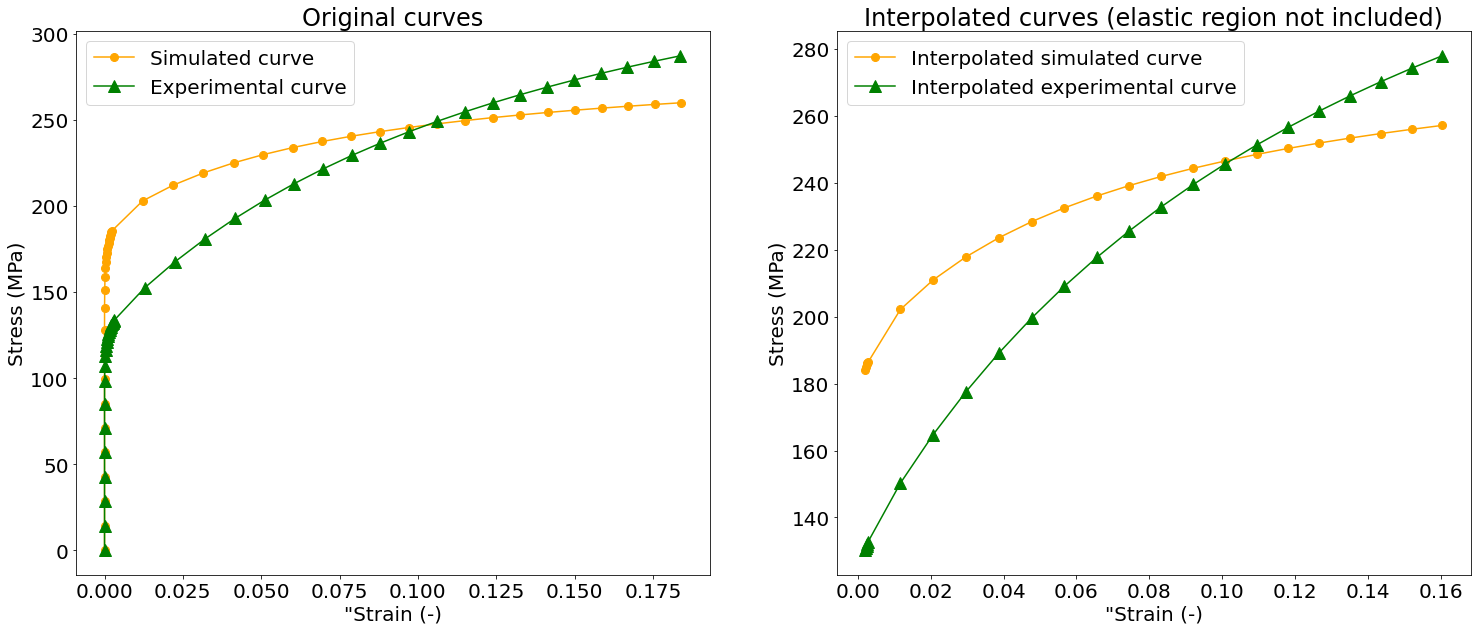

In [53]:
def plotInterpolate(initialSims, pathExp, pathSim):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    # The simulation curves from DAMASK are in true stress-true strain
    # preprocess them into flow curves in order to compare with the experimental curve
    initial_data = np.load(f'{pathSim}/initial_simulations.npy', allow_pickle=True)
    initial_data = initial_data.tolist()
    
    simCurve = list(initial_data.values())[0]
    trueStress = simCurve[1]
    truePlasticStrain = simCurve[0]
    print(truePlasticStrain)
    ax1.plot(truePlasticStrain, trueStress, label = f"Simulated curve",c='orange', marker='.', markersize=16)
    allstrains = list(map(lambda x: x[0], list(initial_data.values())))
    simStrain = np.array(allstrains).mean(axis=0)


    exp_curve = pd.read_csv(pathExp)
    exp_stress = exp_curve.iloc[:,0] # Getting the experimental stress
    exp_strain = exp_curve.iloc[:,1] # Getting the experimental strain
    ax1.plot(exp_strain, exp_stress, label = f"Experimental curve", c="green", marker='^', markersize=12)
    # The common strain points of experimental and simulated curves will be lying between 0.002 (strain of yield stress)
    # and the maximum strain value of experimental curve 
    x_min, x_max = 0.002, exp_strain.max() 
    # prune will be a list of True and False, which indicate which index of the strain to choose from
    prune = np.logical_and(simStrain >= x_min, simStrain <= x_max)
    # sim.strain is the average strains of the initial simulations 
    # Therefore sim.strain is the same for all simulated curves. Now it is pruned
    simStrain = simStrain[prune]
    dropUpperEnd = 2 # Please change this
    # interpolatedStrain will be the interpolating strain for all curves (experimental, initial simulation and iterated simulation)
    interpolatedStrain = simStrain[:-dropUpperEnd]
    print(interpolatedStrain)
    exp_target = interpolatedStressFunction(exp_stress, exp_strain, interpolatedStrain)
    sim_target = interpolatedStressFunction(trueStress, truePlasticStrain, interpolatedStrain)
    print(sim_target)
    ax2.plot(interpolatedStrain, sim_target, label = f"Interpolated simulated curve", c="orange", marker='.', markersize=16) 
    ax2.plot(interpolatedStrain, exp_target, label = f"Interpolated experimental curve", c="green", marker='^', markersize=12) 

    ax1.set_title('Original curves')
    ax1.set(xlabel='"Strain (-)', ylabel='Stress (MPa)')
    ax1.legend(loc=2, prop={'size': 20})
    ax2.set_title('Interpolated curves (elastic region not included)')
    ax2.set(xlabel='"Strain (-)', ylabel='Stress (MPa)')
    ax2.legend(loc=2, prop={'size': 20})
    plt.show()

plotInterpolate(initialSims, pathExp, pathSim)
